# Bayesian Statistics Made Simple

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2020 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## The Bayesian bandit problem

Suppose you have several "one-armed bandit" slot machines, and there's reason to think that they have different probabilities of paying off.

Each time you play a machine, you either win or lose, and you can use the outcome to update your belief about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy, explained below.

First, let's see how to do the update.

## The prior

If we know nothing about the probability of wining, we can start with a uniform prior.

In [2]:
xs = np.linspace(0, 1, 101)
prior = pd.Series(1/101, index=xs)

Here's what it looks like.

In [3]:
def decorate_bandit(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of winning')
    plt.ylabel('PMF')
    plt.title(title)

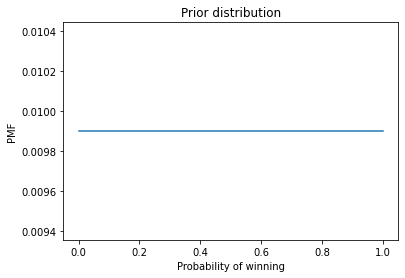

In [4]:
prior.plot()
decorate_bandit('Prior distribution')

## The update

The following function takes a prior distribution and an outcome, either `'W'` or `'L'`.

It does a Bayesian update in place; that is, it modifies the distribution based on the outcome.

In [5]:
def update(pmf, data):
    """Likelihood function for Bayesian bandit
    
    pmf: Series that maps hypotheses to probabilities
    data: string, either 'W' or 'L'
    """
    xs = pmf.index
    if data == 'W':
        pmf *= xs
    else:
        pmf *= 1-xs
        
    pmf /= pmf.sum()

Here's an example that starts with a uniform prior and updates with one win and one loss.

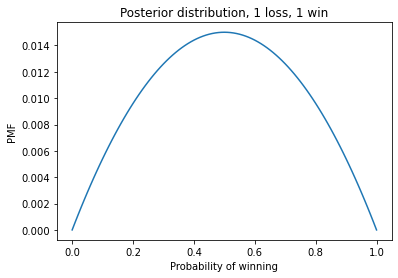

In [6]:
bandit = prior.copy()
update(bandit, 'W')
update(bandit, 'L')
bandit.plot()
decorate_bandit('Posterior distribution, 1 loss, 1 win')

### Exercise 1

Suppose you play a machine 10 times and win once.  What is the posterior distribution of $x$?

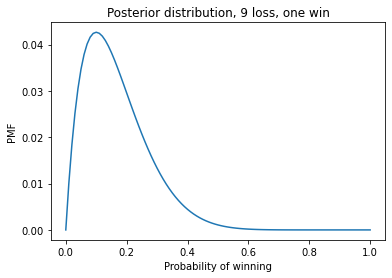

In [7]:
# Solution

bandit = prior.copy()

for outcome in 'WLLLLLLLLL':
    update(bandit, outcome)
    
bandit.plot()
decorate_bandit('Posterior distribution, 9 loss, one win')

## Multiple bandits

Now suppose we have several bandits and we want to decide which one to play.

For this example, we have 4 machines with these probabilities:

In [8]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

The function `play` simulates playing one machine once and returns `W` or `L`.

In [9]:
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def flip(p):
    """Return True with probability p."""
    return np.random.random() < p

def play(i):
    """Play machine i.
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [10]:
for i in range(20):
    result = play(3)
    print(result, end=' ')

L W W W L L L W L W W W L L L W W W W W 

`counter` keeps track of how many times each machine has been played.

In [11]:
counter

Counter({3: 20})

Now I'll make four copies of the prior to represent our beliefs about the four machines.

In [12]:
machines = [prior.copy() for i in range(4)]

This function displays four distributions in a grid.

In [13]:
options = dict(xticklabels='invisible', yticklabels='invisible')

def plot(machines, **options):
    for i, m in enumerate(machines):
        plt.subplot(2, 2, i+1)
        m.plot(label='Machine %s' % i)
        plt.gca().set_yticklabels([])
        plt.legend()
        
    plt.tight_layout()

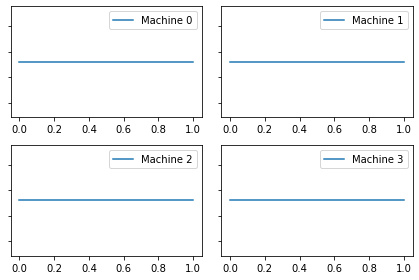

In [14]:
plot(machines)

### Exercise 2

Write a nested loop that plays each machine 10 times and updates them based on the results; then plot the posterior distributions.  

Hint: call `play` and then `update`.

In [15]:
# Solution

for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(machines[i], outcome)

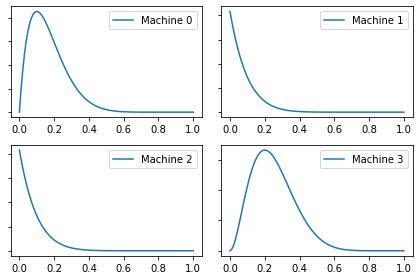

In [16]:
# Solution

plot(machines)

After playing each machine 10 times, we can summarize `machines` by printing the posterior mean and credible interval:

In [17]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [18]:
from scipy.interpolate import interp1d

def credible_interval(pmf, prob):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    prob: probability of the interval
    
    return: pair of float
    """
    # make the CDF
    xs = pmf.index
    ys = pmf.cumsum()
    
    # compute the probabilities
    p = (1-prob)/2
    ps = [p, 1-p]
    
    # interpolate the inverse CDF
    options = dict(bounds_error=False,
                   fill_value=(xs[0], xs[-1]), 
                   assume_sorted=True)
    interp = interp1d(ys, xs, **options)
    return interp(ps)

In [19]:
for i, m in enumerate(machines):
    print(pmf_mean(m), credible_interval(m, 0.9))

0.1668194469884906 [0.02859509 0.35941186]
0.07883360420960964 [0.        0.2295994]
0.07883360420960964 [0.        0.2295994]
0.2500001236675582 [0.07369568 0.46517711]


## Bayesian Bandits

To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it.  The kernel of the Bayesian Bandits algorithm is that it collects and uses data at the same time.  In other words, it balances exploration and exploitation.

The following function chooses among the machines so that the probability of choosing each machine is proportional to its "probability of superiority".

In [20]:
def pmf_choice(pmf):
    """Draw a random sample from a PMF.
    
    pmf: Series representing a PMF
    
    returns: quantity from PMF
    """
    return np.random.choice(pmf.index, p=pmf)

In [21]:
def choose(machines):
    """Use the Bayesian bandit strategy to choose a machine.
    
    Draws a sample from each distributions.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [pmf_choice(m) for m in machines]
    return np.argmax(ps)

This function chooses one value from the posterior distribution of each machine and then uses `argmax` to find the index of the machine that chose the highest value.

Here's an example.

In [22]:
choose(machines)

3

## The strategy

Putting it all together, the following function chooses a machine, plays once, and updates `machines`:

In [23]:
def choose_play_update(machines, verbose=False):
    """Chose a machine, play it, and update machines.
    
    machines: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    # choose a machine
    i = choose(machines)
    
    # play it
    outcome = play(i)
    
    # update beliefs
    update(machines[i], outcome)
    
    if verbose:
        print(i, outcome, pmf_mean(machines[i]))

Here's an example

In [24]:
choose_play_update(machines, verbose=True)

3 L 0.23076939985507136


## Trying it out

Let's start again with a fresh set of machines and an empty `Counter`.

In [25]:
machines = [prior.copy() for i in range(4)]
counter = Counter()

If we run the bandit algorithm 100 times, we can see how `machines` gets updated:

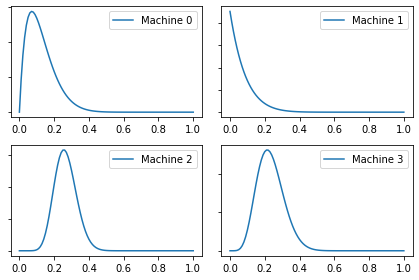

In [26]:
num_plays = 100

for _ in range(num_plays):
    choose_play_update(machines)
    
plot(machines)

We can summarize `machines` by printing the posterior mean and credible interval:

In [27]:
for i, m in enumerate(machines):
    print(pmf_mean(m), credible_interval(m, 0.9))

0.12521873467491973 [0.01974788 0.27462064]
0.07239953242078516 [0.        0.2121182]
0.26530612244897933 [0.16305684 0.36842118]
0.23333333336076842 [0.11396953 0.36311353]


The credible intervals usually contain the true values (0.1, 0.2, 0.3, and 0.4).

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played.  If things go according to plan, the machines with higher probabilities should get played more often.

In [28]:
for i, count in sorted(counter.items()):
    print(i, count)

0 14
1 11
2 47
3 28


### Exercise 3

Go back and run this section again with a different value of `num_play` and see how it does.

The algorithm I presented in this notebook is called [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling).  It is an example of a general strategy called [Bayesian decision theory](https://wiki.lesswrong.com/wiki/Bayesian_decision_theory), which is the idea of using a posterior distribution as part of a decision-making process, usually by choosing an action that minimizes the costs we expect on average (or maximizes the benefits).

In my opinion, strategies like this are the biggest advantage of Bayesian methods over classical statistics.  When we represent knowledge in the form of probability distributions, Bayes's theorem tells us how to change our beliefs as we get more data, and Bayesian decision theory tells us how to use those beliefs to make better decisions.